<a href="https://colab.research.google.com/github/Aravindh4404/FYPSeagullClassification01/blob/main/DenseNet_HQSBNGW_2610.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split  # Import DataLoader and random_split
import numpy as np
import random
import matplotlib.pyplot as plt

# Ensure reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Google Drive Integration for saving models (use in Colab)
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Original Images:


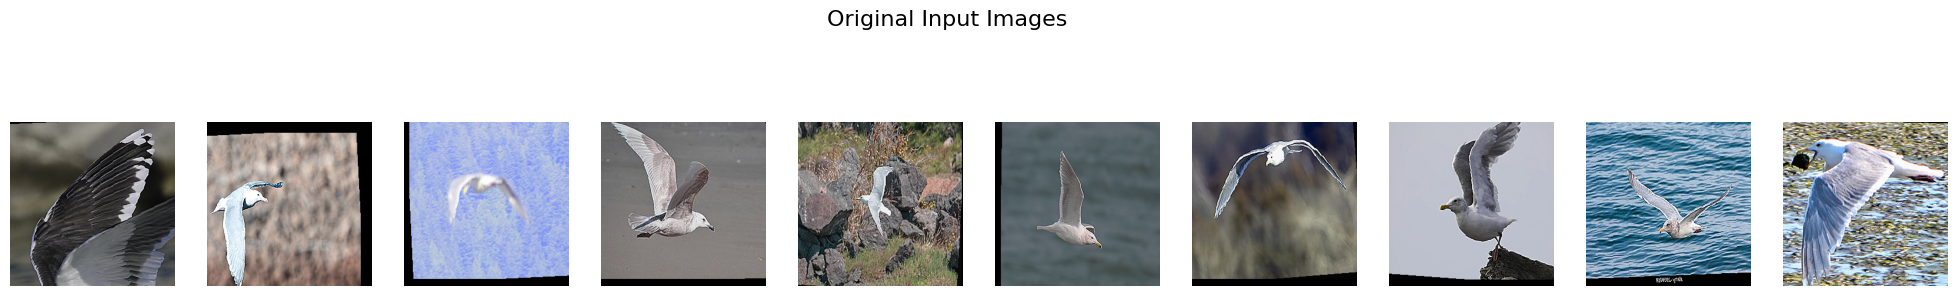

Augmented Samples:


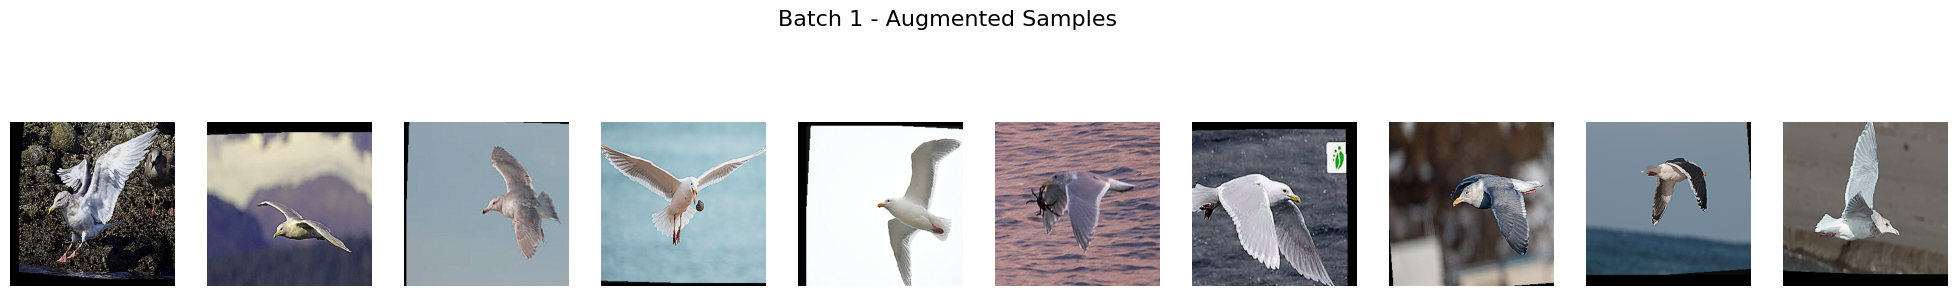

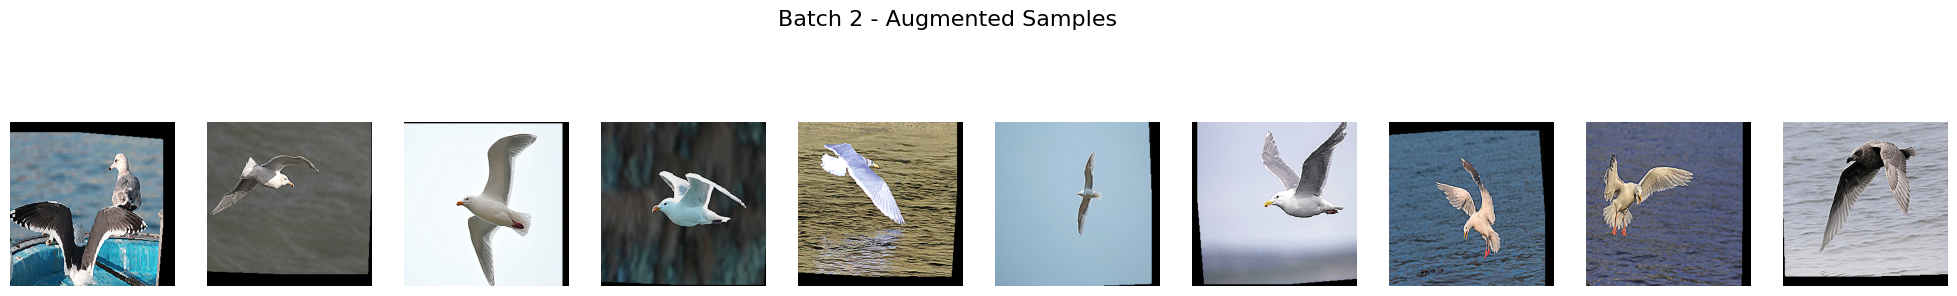

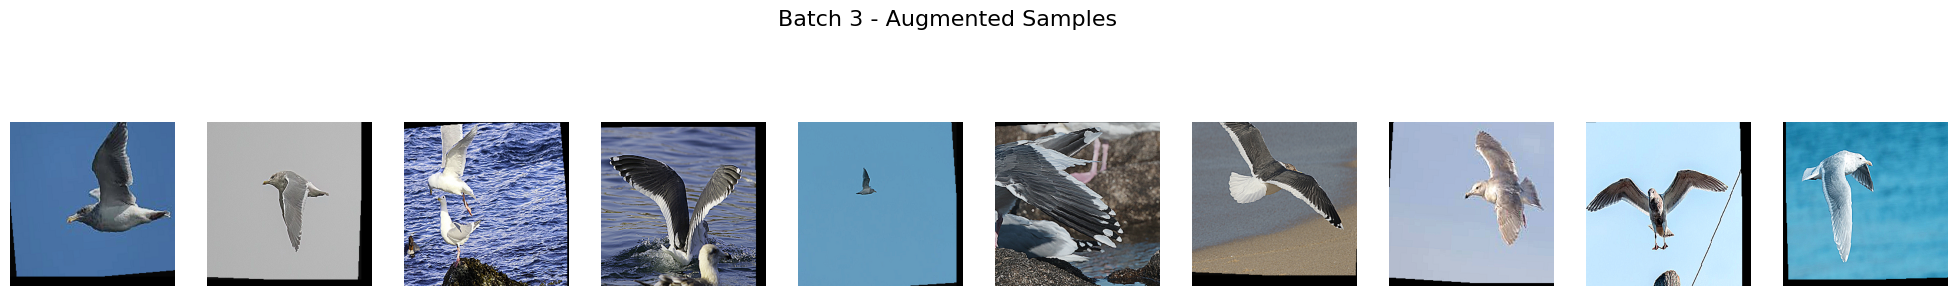

In [ ]:
# Import necessary libraries
import cv2
import numpy as np
from PIL import Image

# Step 1: Image Enhancement for Clarity
def enhance_image(image):
    """Apply basic sharpening to improve image clarity."""
    image = np.array(image)
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])  # Sharpening kernel
    sharpened = cv2.filter2D(src=image, ddepth=-1, kernel=kernel)
    return Image.fromarray(sharpened)

# Step 2: Improved Data Augmentation
transform_train = transforms.Compose([
    transforms.Resize((300, 300)),  # Ensure uniformity in size
    transforms.Lambda(lambda img: enhance_image(img)),  # Apply sharpening to improve clarity
    transforms.RandomHorizontalFlip(p=0.5),  # Horizontal flip
    transforms.RandomRotation(5),  # Small rotation to maintain natural appearance
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),  # Subtle color adjustments
    transforms.RandomCrop(280, padding=20),  # Minor cropping to introduce variation
    transforms.ToTensor(),
])

transform_val_test = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.CenterCrop(256),  # Consistent cropping for validation
    transforms.Lambda(lambda img: enhance_image(img)),  # Ensure clarity in validation images as well
    transforms.ToTensor(),
])

# Step 3: Visualization Functions
def display_original_images(dataset, num_images=10):
    """Visualize original images without any transformations to check their clarity."""
    transform = transforms.Compose([
        transforms.Resize((300, 300)),  # Resize to ensure uniformity, but no augmentation
        transforms.ToTensor()
    ])

    dataset.transform = transform  # Apply basic transformation
    loader = DataLoader(dataset, batch_size=num_images, shuffle=True)
    images, labels = next(iter(loader))

    fig, axes = plt.subplots(1, num_images, figsize=(25, 4))
    for idx, img in enumerate(images):
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        axes[idx].imshow(img)
        axes[idx].axis('off')
    plt.suptitle("Original Input Images", fontsize=16)
    plt.show()

def display_augmentations(dataset, num_images=10, num_batches=3):
    """Visualize a larger number of augmented images to ensure transformations are working as expected."""
    loader = DataLoader(dataset, batch_size=num_images, shuffle=True)

    for batch_idx in range(num_batches):
        data_iter = iter(loader)
        images, labels = next(data_iter)

        fig, axes = plt.subplots(1, num_images, figsize=(25, 4))  # Increase width for clearer display
        for idx, img in enumerate(images):
            img = img.permute(1, 2, 0).numpy()  # Convert from tensor (C, H, W) to (H, W, C)
            img = np.clip(img, 0, 1)  # Ensure pixel values are in range [0,1] for display
            axes[idx].imshow(img)
            axes[idx].axis('off')
        plt.suptitle(f"Batch {batch_idx + 1} - Augmented Samples", fontsize=16)
        plt.show()

# Load datasets
data_path = '/content/drive/My Drive/FYP/Dataset/HQSBNGW/train'
test_data_path = '/content/drive/My Drive/FYP/Dataset/HQSBNGW/test'

train_dataset = datasets.ImageFolder(data_path, transform=transform_train)
test_dataset = datasets.ImageFolder(test_data_path, transform=transform_val_test)

# Split the dataset into 80% training and 20% validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Step 4: Visualize Original and Augmented Samples
print("Original Images:")
display_original_images(train_dataset)

print("Augmented Samples:")
display_augmentations(train_dataset, num_images=10, num_batches=3)

# Define the folder to save model checkpoints
checkpoint_folder = '/content/drive/My Drive/FYP/ModelCheckpointsDenseNet/'
os.makedirs(checkpoint_folder, exist_ok=True)



In [ ]:
# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Step 2: Model Setup - Use DenseNet for Better Feature Utilization
class DenseNetModified(nn.Module):
    def __init__(self):
        super(DenseNetModified, self).__init__()
        self.densenet = models.densenet121(pretrained=True)
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Regularization
            nn.Linear(num_ftrs, 2)
        )

    def forward(self, x):
        return self.densenet(x)

# Initialize the model
model = DenseNetModified()

# Step 3: Define Loss Function, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

# Step 4: Implement Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_acc = None
        self.early_stop = False

    def __call__(self, val_acc, model, folder_path):
        if self.best_acc is None:
            self.best_acc = val_acc
            self.save_model(model, folder_path)
        elif val_acc <= self.best_acc:
            self.counter += 1
            if self.counter >= self.patience:
                if self.verbose:
                    print("Early stopping triggered!")
                self.early_stop = True
        else:
            self.best_acc = val_acc
            self.save_model(model, folder_path)
            self.counter = 0

    def save_model(self, model, folder_path):
        model_save_path = os.path.join(folder_path, "best_densenet_model.pth")
        torch.save(model.state_dict(), model_save_path)
        print(f"Best model saved with accuracy: {self.best_acc:.4f}% at {model_save_path}")

# Initialize early stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

# Step 5: Training, Validation, and Testing Functions
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, early_stopping, epochs=20):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Print the loss per epoch
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.6f}")

        # Validate the model and check accuracy
        val_acc = validate(model, val_loader, criterion)
        scheduler.step(val_acc)
        early_stopping(val_acc, model, checkpoint_folder)

        if early_stopping.early_stop:
            print("Early stopping - training stopped")
            break

def validate(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss/len(loader):.6f}, Accuracy: {accuracy:.2f}%')
    return accuracy

def test(model, loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Loss: {test_loss/len(loader):.6f}, Test Accuracy: {accuracy:.2f}%')

# Step 6: Execute the Code
# Train with early stopping and learning rate scheduling
train(model, train_loader, val_loader, criterion, optimizer, scheduler, early_stopping, epochs=20)

# Evaluate on the test set
test(model, test_loader, criterion)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 181MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  wa

Epoch [1/20], Loss: 0.381856
Validation Loss: 2.992716, Accuracy: 46.20%
Best model saved with accuracy: 46.2025% at /content/drive/My Drive/FYP/ModelCheckpointsDenseNet/best_densenet_model.pth
Epoch [2/20], Loss: 0.243208
Validation Loss: 0.162890, Accuracy: 94.94%
Best model saved with accuracy: 94.9367% at /content/drive/My Drive/FYP/ModelCheckpointsDenseNet/best_densenet_model.pth
Epoch [3/20], Loss: 0.328938
Validation Loss: 1.822132, Accuracy: 86.08%
Epoch [4/20], Loss: 0.245479
Validation Loss: 0.303774, Accuracy: 87.97%
Epoch [5/20], Loss: 0.277166
Validation Loss: 4.364815, Accuracy: 76.58%
Epoch [6/20], Loss: 0.197626
Validation Loss: 1.092912, Accuracy: 67.72%
Epoch [7/20], Loss: 0.195355
Validation Loss: 0.163725, Accuracy: 93.04%
Early stopping triggered!
Early stopping - training stopped
Test Loss: 0.589167, Test Accuracy: 80.49%


Class names: ['Glaucous_Winged_Gull', 'Slaty_Backed_Gull']


<ipython-input-20-88fa7e388f27>:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))


Model loaded for Grad-CAM.


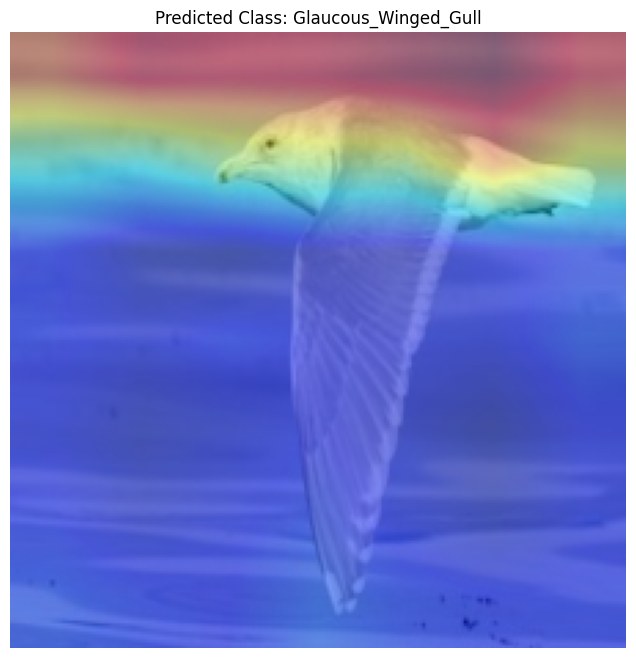

In [20]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models, transforms, datasets
import torch.nn as nn

# Retrieve class names directly from the training dataset directory
data_path = '/content/drive/My Drive/FYP/Dataset/Original_Adult_In-flight/train'
temp_dataset = datasets.ImageFolder(data_path)
class_names = list(temp_dataset.class_to_idx.keys())
print(f"Class names: {class_names}")

# Define the modified DenseNet model (must match the saved model structure)
class DenseNetModified(nn.Module):
    def __init__(self):
        super(DenseNetModified, self).__init__()
        self.densenet = models.densenet121(pretrained=True)
        num_ftrs = self.densenet.classifier.in_features
        self.densenet.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, 2)
        )

    def forward(self, x):
        return self.densenet(x)

# Load the best model checkpoint
def load_model(checkpoint_path):
    model = DenseNetModified()
    model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu')))
    model.eval()
    return model

# Load the trained model
checkpoint_path = '/content/drive/My Drive/FYP/ModelCheckpointsDenseNet/best_densenet_model.pth'
model = load_model(checkpoint_path)
print("Model loaded for Grad-CAM.")

# Preprocess a single image for testing Grad-CAM
def preprocess_image(image_path):
    """Load and preprocess the image."""
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    image = transform(image)
    image = image.unsqueeze(0)  # Add batch dimension
    return image

# Function to predict the class of the given image
def predict_image(model, image_tensor, class_names):
    """Predict the class of an image using the trained model."""
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        return class_names[predicted.item()]

# Grad-CAM function
def generate_gradcam(model, image_tensor, target_layer, class_names):
    features = []
    grads = []

    def save_features_hook(module, input, output):
        features.append(output)

    def save_grads_hook(module, grad_in, grad_out):
        grads.append(grad_out[0])

    # Register hooks for feature map and gradients
    hook1 = target_layer.register_forward_hook(save_features_hook)
    hook2 = target_layer.register_backward_hook(save_grads_hook)

    # Forward pass
    output = model(image_tensor)
    predicted_class_idx = output.argmax().item()
    predicted_class_name = class_names[predicted_class_idx]

    # Backward pass for Grad-CAM
    model.zero_grad()
    class_loss = output[0, predicted_class_idx]
    class_loss.backward()

    # Get gradients and feature maps
    gradient = grads[0].cpu().data.numpy()[0]
    feature_map = features[0].cpu().data.numpy()[0]

    # Calculate Grad-CAM
    weights = np.mean(gradient, axis=(1, 2))
    cam = np.zeros(feature_map.shape[1:], dtype=np.float32)

    for i, w in enumerate(weights):
        cam += w * feature_map[i]

    cam = np.maximum(cam, 0)  # ReLU to remove negative values
    cam = cv2.resize(cam, (image_tensor.shape[3], image_tensor.shape[2]))
    cam -= np.min(cam)
    cam /= np.max(cam)

    # Convert original image to show on heatmap
    original_image = image_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    original_image = original_image - np.min(original_image)
    original_image = original_image / np.max(original_image)

    # Create heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam_image = 0.4 * heatmap + 0.6 * original_image

    # Show the image with the predicted class name
    plt.figure(figsize=(8, 8))
    plt.title(f"Predicted Class: {predicted_class_name}")
    plt.imshow(cam_image)
    plt.axis('off')
    plt.show()

    # Remove hooks
    hook1.remove()
    hook2.remove()

# Test the Grad-CAM on a specific image
test_image_path = '/content/image_501.jpg'  # Path to your sample image
image_tensor = preprocess_image(test_image_path)

# Select the target layer in the model for Grad-CAM
target_layer = model.densenet.features[-1]
generate_gradcam(model, image_tensor, target_layer, class_names)
